In [59]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import model_selection
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from scipy.spatial import cKDTree
# from xgboost import XGBRegressor
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt
# import nichepca as npc
# import wandb
# from utils import find_closest_points
# import gensim
# from gensim.models import word2vec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read data & see the differences in the two slides


In [60]:
adata_msi_a1_full = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/V11L12-109/V11L12-109_A1/V11L12-109_A1.MSI_MOSCOT_paired.h5ad')
adata_rna_a1 = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/V11L12-109/V11L12-109_A1/V11L12-109_A1.RNA_MOSCOT_paired.h5ad')
adata_msi_b1_full = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/V11L12-109/V11L12-109_B1/V11L12-109_B1.MSI_MOSCOT_paired.h5ad')
adata_rna_b1 = sc.read('/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/V11L12-109/V11L12-109_B1/V11L12-109_B1.RNA_MOSCOT_paired.h5ad')



Remove m/z below FMP10, because most likely this is noise 

In [61]:
adata_msi_a1_full.var_names

Index(['156.26059', '156.26195', '156.48344', '156.4838', '156.485',
       '157.54681', '158.41217', '160.02547', '170.45622', '170.45738',
       ...
       '1044.29885', '1044.3523', '1046.31366', '1046.32671', '1046.33977',
       '1046.36442', '1048.32025', '1048.3319', '1048.34354', '1048.38431'],
      dtype='object', length=1538)

In [62]:
adata_msi_a1 = adata_msi_a1_full[:, adata_msi_a1_full.var_names.astype(float) > 288.15].copy()
adata_msi_b1 = adata_msi_b1_full[:, adata_msi_b1_full.var_names.astype(float) > 288.15].copy()

In [63]:
adata_msi_a1

AnnData object with n_obs × n_vars = 2438 × 1361
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    var: 'technology', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

QC

In [64]:
sc.pp.calculate_qc_metrics(adata_msi_a1, inplace=True)
sc.pp.calculate_qc_metrics(adata_msi_b1, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

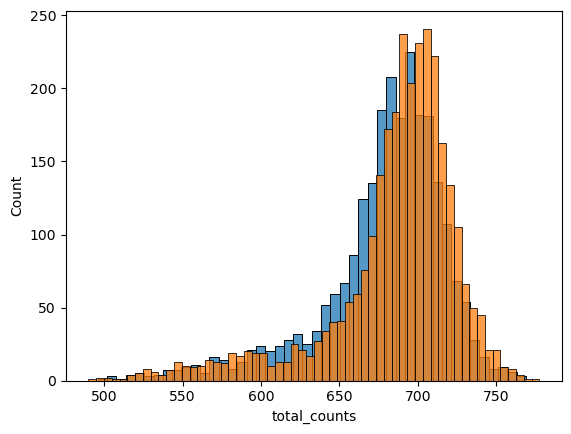

In [65]:
sns.histplot(adata_msi_a1.obs.total_counts)
sns.histplot(adata_msi_b1.obs.total_counts)


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

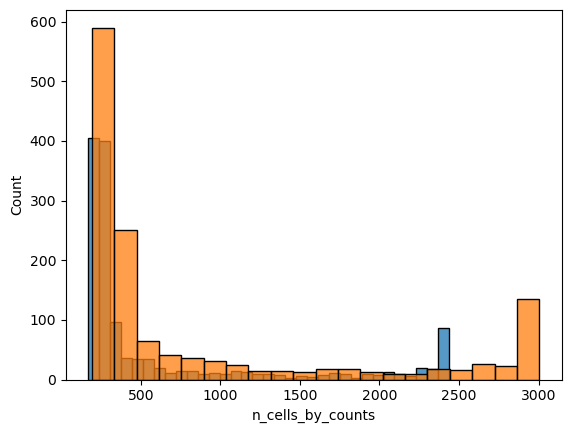

In [66]:
sns.histplot(adata_msi_a1.var.n_cells_by_counts)
sns.histplot(adata_msi_b1.var.n_cells_by_counts)

In [67]:
adata_msi_a1.var.n_cells_by_counts.describe()

count    1361.000000
mean      639.006613
std       702.061076
min       171.000000
25%       233.000000
50%       280.000000
75%       620.000000
max      2438.000000
Name: n_cells_by_counts, dtype: float64

In [68]:
adata_msi_b1.var.n_cells_by_counts.describe()

count    1361.000000
mean      880.500367
std       944.158342
min       192.000000
25%       277.000000
50%       354.000000
75%      1078.000000
max      3005.000000
Name: n_cells_by_counts, dtype: float64

Removing highly abundant m/z because this is also most likely noise 

In [69]:
sc.pp.filter_genes(adata_msi_a1, max_cells=650)
sc.pp.filter_genes(adata_msi_b1, max_cells=650)


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

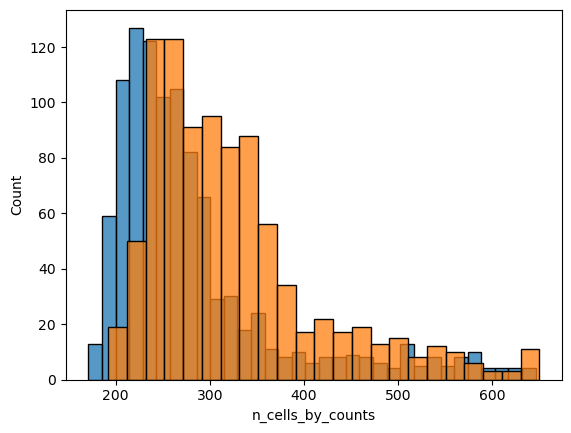

In [70]:
sns.histplot(adata_msi_a1.var.n_cells_by_counts)
sns.histplot(adata_msi_b1.var.n_cells_by_counts)

<Axes: xlabel='total_counts', ylabel='Count'>

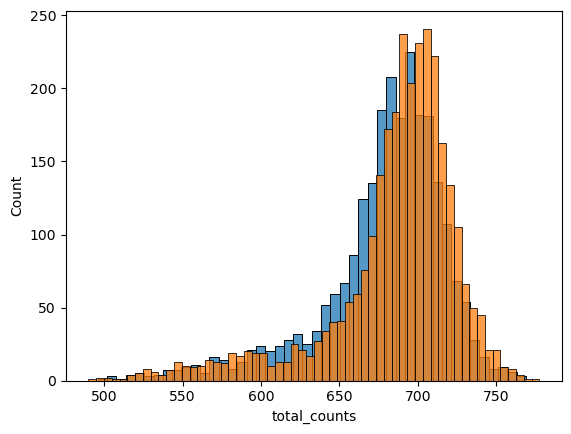

In [71]:
sns.histplot(adata_msi_a1.obs.total_counts)
sns.histplot(adata_msi_b1.obs.total_counts)

Read metabolite annotations from the FMP10 paper

In [ ]:
names = pd.read_csv("/lustre/groups/ml01/workspace/eirini.giannakoulia/datasets/FMP10_metabolite_weights.csv").iloc[:, :2]
names

,Compound,Observed Mass (m/z),Observed Mass (m/z) coarse
0,[D-Ala2]-Met-enkephalin double,1122.46,1122.5
1,[D-Ala2]-Met-enkephalin double (*),1108.44,1108.4
2,[D-Ala2]-Met-enkephalin single,855.35,855.4
3,3 4-dihydroxyphenylacetone,701.28,701.3
4,3 4-dihydroxyphenylacetone double (*),687.27,687.3
...,...,...,...
136,Tyramine double (*),658.90,658.9
137,Valine single,385.19,385.2
138,Vanillactic acid,480.18,480.2
139,Vanilpyruvate,478.17,478.2


In [73]:
names["Observed Mass (m/z) coarse"] = names["Observed Mass (m/z)"].round(1)

In [74]:
m_z = adata_msi_a1.var_names.astype(float).round(1)

Coarsly annotating metabolites

In [75]:
len(set(names["Observed Mass (m/z) coarse"]).intersection(set(m_z)))

new_vars_a1 = []
for col in adata_msi_a1.var_names.astype(float).round(1):
    if col in names["Observed Mass (m/z) coarse"].tolist() and names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].shape[0] == 1:
        new_vars_a1.append(names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].tolist()[0])
    else:
        new_vars_a1.append(str(col))


In [76]:
new_vars_b1 = []
for col in adata_msi_b1.var_names.astype(float).round(1):
    if col in names["Observed Mass (m/z) coarse"].tolist() and names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].shape[0] == 1:
        new_vars_b1.append(names.loc[names["Observed Mass (m/z) coarse"] == col]["Compound"].tolist()[0])
    else:
        new_vars_b1.append(str(col))

In [77]:
adata_msi_a1.var_names_new = new_vars_a1
adata_msi_b1.var_names_new = new_vars_b1


In [79]:
adata_msi_a1.var_names_new


['289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '291.1',
 '294.1',
 '295.1',
 '296.1',
 '296.1',
 '296.1',
 '296.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.2',
 '298.1',
 '298.1',
 '298.1',
 '298.2',
 '299.1',
 '299.1',
 '299.2',
 '300.1',
 '300.1',
 '301.1',
 '301.1',
 '301.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '303.1',
 '303.1',
 '303.1',
 '303.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '305.1',
 '306.1',
 '307.1',
 '308.1',
 '309.1',
 '309.1',
 '310.1',
 '310.1',
 '310.1',
 '310.1',
 '311.1',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '312.1',
 '312.1',
 '312.1',
 '312.2',
 '312.2',
 '313.2',
 '313.2',
 '314.2',
 '316.1',
 '316.2',
 '318.2',
 '320.1',
 '321.1',
 '322.1',
 '323.2',
 '324.1',
 '324.1',
 '324.1',
 '324.1',
 '324.2',
 '324.2',
 '325.1',
 '325.2',


In [80]:
adata_msi_b1.var_names_new

['289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '289.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '290.1',
 '291.1',
 '294.1',
 '295.1',
 '296.1',
 '296.1',
 '296.1',
 '296.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.1',
 '297.2',
 '298.1',
 '298.1',
 '298.1',
 '298.2',
 '299.1',
 '299.1',
 '299.2',
 '300.1',
 '300.1',
 '301.1',
 '301.1',
 '301.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '302.1',
 '303.1',
 '303.1',
 '303.1',
 '303.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '304.1',
 '305.1',
 '306.1',
 '307.1',
 '308.1',
 '309.1',
 '309.1',
 '310.1',
 '310.1',
 '310.1',
 '310.1',
 '311.1',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '311.2',
 '312.1',
 '312.1',
 '312.1',
 '312.2',
 '312.2',
 '313.2',
 '313.2',
 '314.2',
 '316.1',
 '316.2',
 '318.2',
 '320.1',
 '321.1',
 '322.1',
 '323.2',
 '324.1',
 '324.1',
 '324.1',
 '324.2',
 '324.2',
 '325.1',
 '325.2',
 '326.1',


Plotting some of metabolite expressions

In [69]:
# for i, col in enumerate(adata_msi.var_names_new):
#     try:
#         a= float(col)
#         continue
#     except:
#         sns.scatterplot(x=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].obsm["spatial_warp"][:, 0], 
#                         y=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].obsm["spatial_warp"][:, 1], 
#                         c=adata_msi[adata_msi.obs.slide == "V11L12-109_A1"].X[:, i].flatten(),
#                        s=15)
#         plt.title(col)
#         plt.show()

In [ ]:
sq.gr.spatial_neighbors(adata_msi_a1, spatial_key='spatial_warp')
sq.gr.spatial_neighbors(adata_msi_b1, spatial_key='spatial_warp')


In [ ]:
print(adata_msi_a1)
print(adata_msi_b1)

AnnData object with n_obs × n_vars = 5443 × 1026
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Checking is some m/z are spatially variable after removing noize

In [ ]:
sq.gr.spatial_autocorr(adata_msi_a1)
sq.gr.spatial_autocorr(adata_msi_b1)

In [ ]:
adata_msi_a1.uns["moranI"].loc[adata_msi_a1.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_index()
adata_msi_a1.uns["moranI"].loc[adata_msi_a1.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_index()


,I,pval_norm,var_norm,pval_norm_fdr_bh
1006.2271,0.022269,1.004602e-03,0.000053,3.036990e-02
400.18521,0.022781,7.905536e-04,0.000053,2.589063e-02
435.20692,0.431915,0.000000e+00,0.000053,0.000000e+00
445.09869,0.023735,4.998920e-04,0.000053,1.785978e-02
569.25386,0.024726,3.052923e-04,0.000053,1.199799e-02
674.2805,0.264561,0.000000e+00,0.000053,0.000000e+00
674.28592,0.396906,0.000000e+00,0.000053,0.000000e+00
674.28833,0.442162,0.000000e+00,0.000053,0.000000e+00
675.28961,0.189879,0.000000e+00,0.000053,0.000000e+00
675.29202,0.325730,0.000000e+00,0.000053,0.000000e+00


In [ ]:
adata_msi_a1
adata_msi_a1

AnnData object with n_obs × n_vars = 5443 × 1026
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable', 'msi_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'hvg', 'msi_concat_clusters', 'neighbors', 'pca', 'slide_colors', 'umap', 'spatial_neighbors', 'moranI'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
adata_msi_a1.uns["moranI"].loc[adata_msi_a1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.round(1)
adata_msi_a1.uns["moranI"].loc[adata_msi_a1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)
inter_a1 = list(set(adata_msi_a1.uns["moranI"].loc[adata_msi_a1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)).intersection(set(names["Observed Mass (m/z) coarse"])))

Index(['674.28833', '435.20692', '674.28592', '675.29202', '674.2805',
       '675.28961', '858.31325', '805.33878', '843.3189', '569.25386',
       '445.09869', '400.18521', '1006.2271', '682.12245'],
      dtype='object')

In [ ]:
adata_msi_b1.uns["moranI"].loc[adata_msi_b1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.round(1)
adata_msi_b1.uns["moranI"].loc[adata_msi_b1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)
inter_b1 = list(set(adata_msi_b1.uns["moranI"].loc[adata_msi_b1.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)).intersection(set(names["Observed Mass (m/z) coarse"])))

In [ ]:
names.loc[names["Observed Mass (m/z) coarse"].isin(inter_a1)]


,Compound,Observed Mass (m/z),Observed Mass (m/z) coarse
6,3-MT,435.21,435.2


In [ ]:
names.loc[names["Observed Mass (m/z) coarse"].isin(inter_b1)]

In [39]:
names

,Compound,Observed Mass (m/z),Observed Mass (m/z) coarse
0,[D-Ala2]-Met-enkephalin double,1122.46,1122.5
1,[D-Ala2]-Met-enkephalin double (*),1108.44,1108.4
2,[D-Ala2]-Met-enkephalin single,855.35,855.4
3,3 4-dihydroxyphenylacetone,701.28,701.3
4,3 4-dihydroxyphenylacetone double (*),687.27,687.3
...,...,...,...
136,Tyramine double (*),658.90,658.9
137,Valine single,385.19,385.2
138,Vanillactic acid,480.18,480.2
139,Vanilpyruvate,478.17,478.2
